In [1]:
import warnings
import time
warnings.filterwarnings('ignore')
#import tensorflow as tf # This may laod Tensorflow 2.0.0 if that is the verison of the package on your distribution
import tensorflow.compat.v1 as tf #for tensorflow 1
print(tf.__version__)
tf.disable_v2_behavior() # Only needed if using tensorflow 1 with tensorflow 2 being the package avlaiable  
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from sklearn import preprocessing
from sklearn.decomposition import PCA
%matplotlib inline

2.1.0
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from scipy.stats import norm

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size       = x_train.shape[1]
original_dim     = image_size * image_size

# Flatten each image to be a vector (as opposed to [28,28])
x_train          = np.reshape(x_train, [-1, original_dim])
x_test           = np.reshape(x_test, [-1, original_dim])
x_train          = x_train.astype('float32') / 255
x_test           = x_test.astype('float32') / 255

# Visualisation parameters (for after the implementation of the VAE - start playing with these after the VAE seems to work!)
n                = 29 # Number of digits to show per row / col
dsize            = 28 # Digit size

z1               = norm.ppf(np.linspace(0.01, 0.99, n))
z2               = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid           = np.dstack(np.meshgrid(z1, z2))

Zf               = lambda x : sess.run(z_mean, feed_dict = {t_X : x})
Xf               = lambda z_grid : sess.run(t_X_hat, feed_dict = {z : z_grid.reshape(n * n, nlatent)}).reshape(n, n, dsize, dsize)

def get_batch(*args, size):
    """ Loops through each argument in batches of [size] """
    
    n = len(args[0])
    if size is None or size >= n:
        yield from args
        return None
    r = np.random.permutation(n)
    for i in range(n // size + 1):
        yield (arg[r[i * size : (i + 1) * size]] for arg in args)
        
def visualise(X, y, sep = 2):
    """ Visualise the mapped 2D manifold """
    
    Z  = Zf(x_test)
    Xh = Xf(z_grid)
    
    plt.figure(figsize = (12, 10))
    plt.scatter(Z[:, 0], Z[:, 1], c = y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.figure(figsize = (12, 10))
    plt.imshow(np.block(list(map(list, Xh))), cmap = 'gray')
    start_range    = dsize // 2
    end_range      = n * dsize + start_range
    pixel_range    = np.arange(start_range, end_range, dsize)
    sample_range_x = np.round(z1, 2)
    sample_range_y = np.round(z2, 2)
    plt.xticks(pixel_range[::sep], sample_range_x[::sep])
    plt.yticks(pixel_range[::sep], sample_range_y[::sep])

In [3]:
x_train.shape

(60000, 784)

In [4]:
# Hyperparameters...
layers   = [512, 256, 128]
nlatent  = 2
batch    = 128
epochs   = 30
alpha    = 1e-3



# General dtype to use
dtype    = 'float32'

# Number of features
m        = x_train.shape[1]

startT = time.time()

# Reset the graph to ensure blank graph initially...
tf.reset_default_graph()

# Define placeholder for 'X' data
t_X      = tf.placeholder(dtype = dtype, shape = [None, m], name = 'X')

# Define how t_X maps to the layer before the latent space
with tf.name_scope('Encoder'):
    h        = t_X
    for i, layer in enumerate(layers, 1):
        with tf.name_scope(f'Layer_{i}'):
            ######### Map how we get from the previous layer to the next hidden layer #########
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
# Define how we get the mean and variance from the previous hidden layer
with tf.name_scope('Latent'):
    
    with tf.name_scope('Mean'):
        z_mean   = tf.layers.dense(inputs=h, units=nlatent)

    with tf.name_scope('Log_Variance'):
        z_log_var    = tf.layers.dense(inputs=h, units=1)
        
    # Code the "reparameterisation trick"
    with tf.name_scope('Sample'):
        epsilon  = tf.random_normal(tf.shape(z_mean), mean=0, stddev=1)
        z_sample = z_mean + tf.math.exp(z_log_var / 2)*epsilon
        z        = tf.placeholder_with_default(z_sample, shape = [None, nlatent], name = 'z')


# Define how "z" decodes to our reconstructed "t_X" estimate
with tf.name_scope('Decoder'):
    h        = z
    for i, layer in enumerate(layers[::-1], 1):
        with tf.name_scope(f'Layer_{i}'):
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
    with tf.name_scope('Final'):
        t_X_hat  = tf.layers.dense(inputs=h, units=m, activation=tf.nn.sigmoid)

        
# Define the loss function as defined in the derivation section
with tf.name_scope('Loss'):
    with tf.name_scope('AutoEncoder'):
        # The normal AutoEncoder loss should measure how far our t_X_hat is from t_X
        #Note that we can ignore sigma in this calculation, as the regularisation will mean sigma ~ 1
        loss_ae = tf.losses.mean_squared_error(t_X_hat,t_X) 
        loss_ae = tf.math.scalar_mul(m/2, loss_ae) #so squared-error
        
    with tf.name_scope('KL_Divergence'):
        # The KL-divergence between z and a standard normal you derived earlier
        loss_kl = 1 + z_log_var - tf.math.exp(z_log_var) - tf.math.square(z_mean)
        loss_kl = tf.math.reduce_sum(loss_kl, axis=-1) 
        loss_kl *= -0.5
        
    loss = tf.reduce_mean(loss_ae + loss_kl, name = 'loss')

# Define final components before training the model
optim    = tf.train.AdamOptimizer(alpha).minimize(loss)
train    = {t_X : x_train}

sess     = tf.InteractiveSession()
writer   = tf.summary.FileWriter('./VAE_MLP_logdir', sess.graph)
sess.run(tf.global_variables_initializer())

# Gradient descent loop with verbose loss check...
# Hopefully we see our loss reduce!

train_losses = []
test_losses = []


for i in range(epochs):
    losses  = []
    for xb, in get_batch(x_train, size = batch):
        nb = len(xb)
        sess.run(optim, feed_dict = {t_X : xb})
        losses.append(nb * sess.run(loss, feed_dict = {t_X : xb}))
        print(f'\rIteration {i:2d}: loss = {losses[-1] / nb:6,.2f}', end = '')
    print(f'\rIteration {i:2d}: loss = {sum(losses) / len(x_train):6,.2f}')
    train_losses.append(sess.run(loss, feed_dict = {t_X: x_train}))
    test_losses.append(sess.run(loss, feed_dict = {t_X: x_test}))
    
timeTaken = int(time.time() - startT)

print(timeTaken,'s taken')

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Iteration  0: loss =  26.40
Iteration  1: loss =  22.68
Iteration  2: loss =  21.61
Iteration  3: loss =  21.12
Iteration  4: loss =  20.82
Iteration  5: loss =  20.59
Iteration  6: loss =  20.43
Iteration  7: loss =  20.26
Iteration  8: loss =  20.16
Iteration  9: loss =  20.07
Iteration 10: loss =  20.04
Iteration 11: loss =  19.96
Iteration 12: loss =  19.86
Iteration 13: loss =  19.83
Iteration 14: loss =  19.78
Iteration 15: loss =  19.75
Iteration 16: loss =  19.74
Iteration 17: loss =  19.65
Iteration 18: loss =  19.67
Iteration 19: loss =  19.62
Iteration 20: loss =  19.57
Iteration 21: loss =  19.55
Iteration 22: loss =  19.52
Iteration 23: loss =  19.48
Iteration 24: loss =  19.49
Iteration 25: loss =  19.45
Iteration 26: loss =  19.48
Iteration 27: loss =  19.45
Iteration 28: loss =  19.45
Iteration 29: loss =  19.40
66 s taken


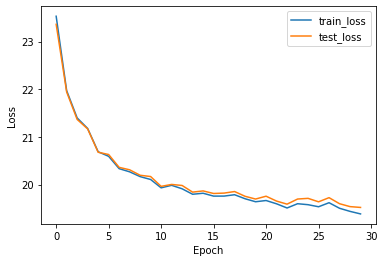

In [5]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [6]:
#Need to try different output layer types:

#sigmoid was decent: loss of 33.8, results looked quite good
#tanh didnt improve this much with 34.2; arguably worse surpirisingly
#relu does surpisingly poorly actually 37.5, perhaps the restriction of negative value outputs on argument restrics capacity
#no activation: loss of 34.0, quite well, joint with sigmoid; naturally trains faster also!

#Go for sigmoid as it effectively restricts output values to [0,1] for pixels!

In [7]:
#Got 34ish with 64 batch
#Trying 128 batch: Trains significantly faster, loss value still 34
#256 batch loss got worse at 34.9
#32 batch also performs worse and very slowly

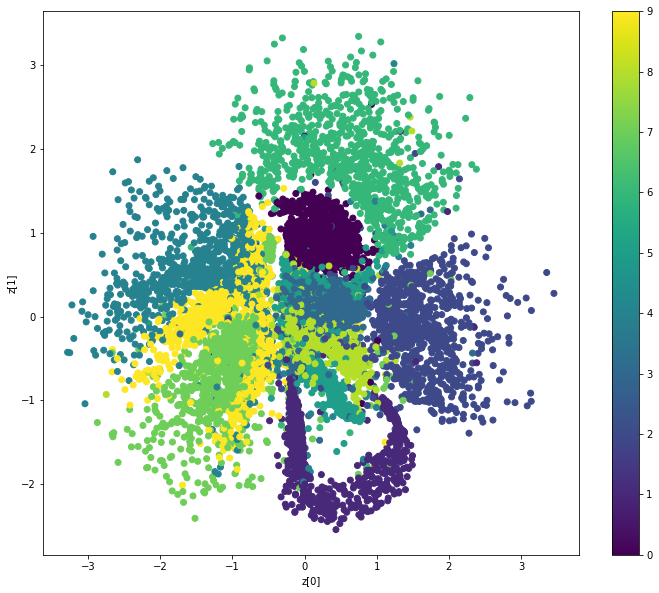

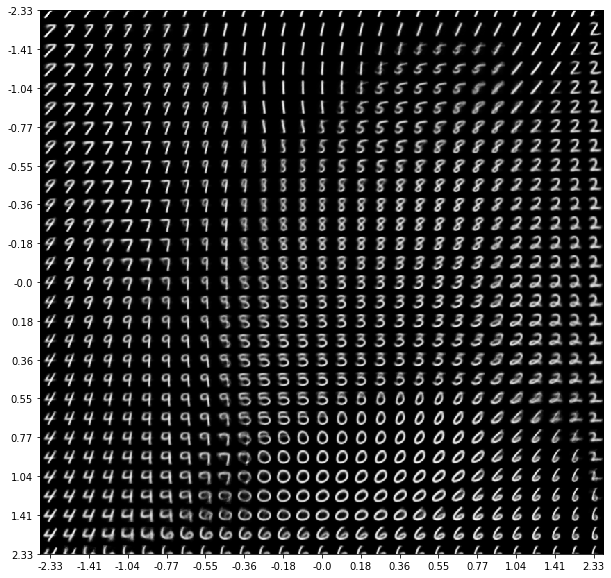

In [8]:
visualise(x_test, y_test)

In [9]:
def gen_digit(low=-2,high=2):
    z1,z2 = np.random.uniform(low,high,2)
    Z = [[z1,z2]]
    digit = sess.run(t_X_hat, feed_dict={z: Z})
    digit = digit[0] #strip off outer bracket
    return digit

def plot_digit(digit):
    digit = np.reshape(digit,(28,28))
    plt.imshow(digit,interpolation='nearest', cmap='gray')
    plt.show()

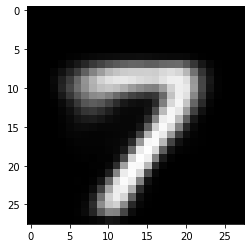

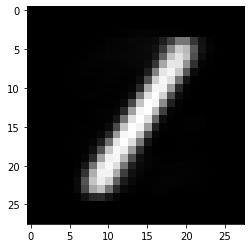

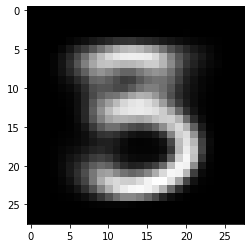

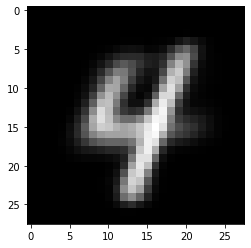

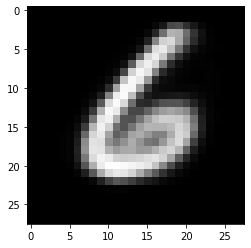

In [10]:
for d in range(5):
    plot_digit(gen_digit())

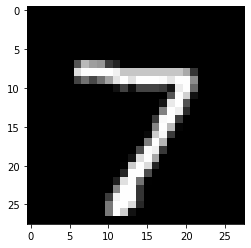

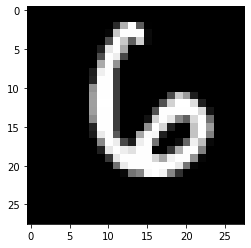

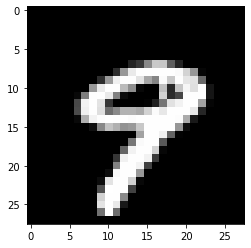

In [11]:
plot_digit(x_test[0])
plot_digit(x_test[88])
plot_digit(x_test[9])

In [12]:
x_test_out = sess.run(t_X_hat, feed_dict = {t_X: x_test})

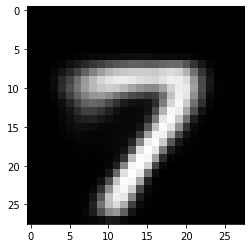

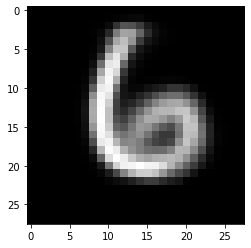

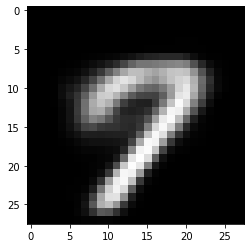

In [13]:
plot_digit(x_test_out[0])
plot_digit(x_test_out[88])
plot_digit(x_test_out[9])